### Imports et initialisations

In [19]:
import numpy as np
import random
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [20]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/1M_Min_clusters/"
clean_dataset_file = "datasets/MillionTweetsMin_NEFU.txt"
raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

### Chargement des données en mémoire

In [21]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
clean_dataset = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_dataset = file.read().splitlines()

### Création des échantillons
Ne pas exécuter pour travailler avec toutes les données

In [12]:
sample_size = 5000

idx_list = random.sample(range(len(clean_dataset)), sample_size)
clean_dataset = [clean_dataset[i] for i in idx_list]
raw_dataset = [raw_dataset[i] for i in idx_list]

### Encodage du jeu de données

On charge le modèle depuis le disque

In [22]:
from gensim.models import KeyedVectors

In [23]:
model = KeyedVectors.load("models/w2vec_model_d300_global_Min")
dim = 300

In [24]:
# Encode un message
# msg : liste de chaînes de caractères correspondant aux mots du message
# model : le modèle utilisé pour l'encodage
# dim : la dimension des vecteurs mots dans ce modèle
# Renvoie un vecteur qui est la moyenne de tous les vecteurs correspondants aux mots du message
# Si aucun mot du message n'est dans le modèle, renvoie un vecteur de zéros.
def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [25]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 31.4 s, sys: 589 ms, total: 32 s
Wall time: 32 s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la partie encodeur de notre autoencoder
- Puis on compare avec PCA

In [27]:
encoder = keras.models.load_model("models/two_dim_encoder_deep")

In [28]:
%%time
two_dim_dataset = encoder.predict(dataset_encoded)

2022-05-24 16:14:35.773952: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 789610800 exceeds 10% of free system memory.
2022-05-24 16:14:36.056922: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 789610800 exceeds 10% of free system memory.


CPU times: user 21.5 s, sys: 1.92 s, total: 23.4 s
Wall time: 14.7 s


In [30]:
b = two_dim_dataset.T

In [31]:
# Initialisation des variables globales pour le module clustertools
init_globals(clean_dataset, raw_dataset, two_dim_dataset, cluster_dir)

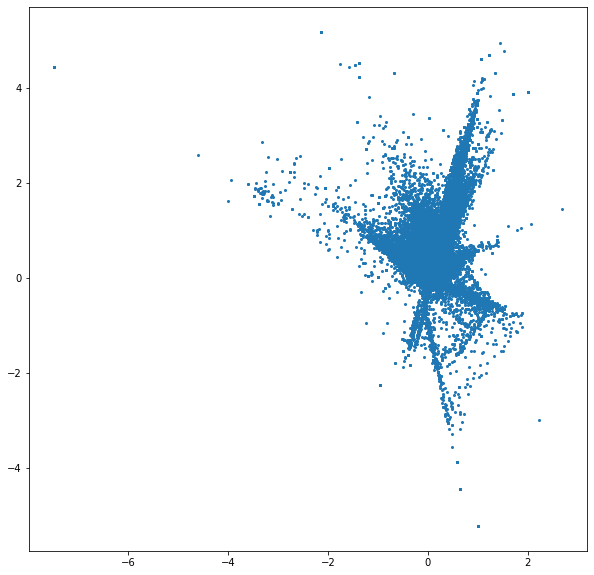

In [33]:
#Affichage des données
plt.scatter(b[0], b[1], marker='.')
plt.show()

In [34]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
pca_two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 55 s, sys: 12.8 s, total: 1min 7s
Wall time: 10.9 s


In [35]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
pca = pca_two_dim_dataset.T

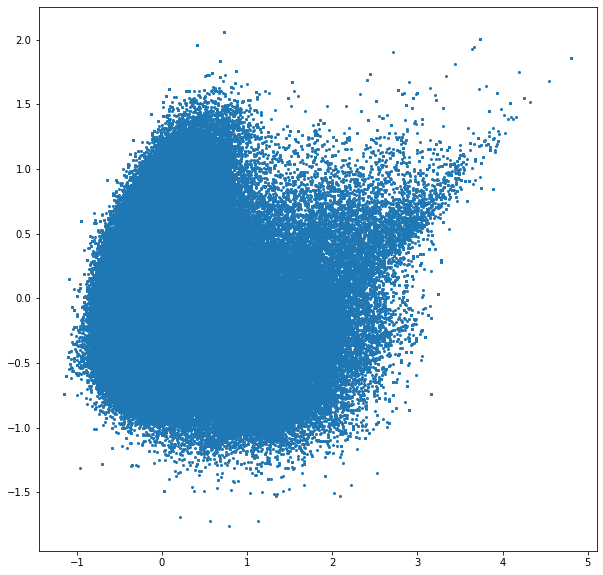

In [36]:
#Affichage des données
plt.scatter(pca[0], pca[1], marker='.')
plt.show()

### Kmeans

Pour mémoire : méthode de calcul du nombre idéal de clusters avec la méthode du coude (elbow method)
```python
sum_of_squared_dist = []
for k in range(1, 60):
    km = KMeans(n_clusters=k)
    km.fit(dataset_encoded)
    sum_of_squared_dist.append(km.inertia_)
    
plt.plot(range(1, 60), sum_of_squared_dist, 'bx-')
plt.show
```

In [37]:
n_clust = 15

In [ ]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 24min 1s, sys: 27.6 s, total: 24min 28s
Wall time: 3min 29s


In [ ]:
%%time 
km_pred = kmeans.predict(dataset_encoded)

CPU times: user 1.77 s, sys: 601 ms, total: 2.37 s
Wall time: 628 ms


In [42]:
%%time
km_centers = [[r[0] for r in model.similar_by_vector(center)] for center in km_model.cluster_centers_]

CPU times: user 1.2 s, sys: 608 ms, total: 1.81 s
Wall time: 259 ms


Cluster 0 : 6478 messages
25 messages contiennent un mot-clé haineux (soit 0.39%)
Les 20 mots les plus fréquents : ah oui oh ouais bah ok non eh ouin bon ben bien ahhh moi mdr ouai toi .. d’accord c 
Les mots les plus proches du centre : haaa haaaa ouais? mddrrrrr ouaiiis ouaaaaais okk commence? oeee raah 

Cluster 1 : 64095 messages
488 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : j’ai trop mon c moi ma j'ai wsh t’es toi quoi bien va là elle vraiment jsuis y’a mdr bon 
Les mots les plus proches du centre : prsq jsai filme. narvalo c’pas bahah indécis, ptdrrrr, mood. d’explication 

Cluster 2 : 18248 messages
33 messages contiennent un mot-clé haineux (soit 0.18%)
Les 20 mots les plus fréquents : sfft20160805 testgeohierarchy dc bsgstaliation sisoi naurr #cashapp13plus nsfwtweet bsgstgalore testgeocode sore testplace #fortune4days grité fabulous! bsgsthumping bsgst #boycottmzetxaptxgma255 bsgstanglican moin! 
Les mots les plus proches du centre 

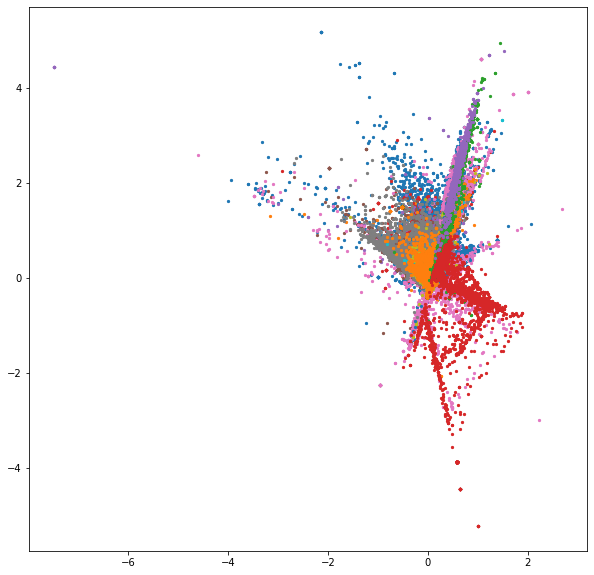

CPU times: user 19.5 s, sys: 332 ms, total: 19.9 s
Wall time: 19.8 s


In [43]:
%%time
parse_no_save(km_pred, km_centers)

In [61]:
np.save(cluster_dir + "km_" + str(n_clust) + "/clusters_centers.npy" ,km_model.cluster_centers_)

In [44]:
init_globals(clean_dataset, raw_dataset, pca_two_dim_dataset, cluster_dir)

Cluster 0 : 6478 messages
25 messages contiennent un mot-clé haineux (soit 0.39%)
Les 20 mots les plus fréquents : ah oui oh ouais bah ok non eh ouin bon ben bien ahhh moi mdr ouai toi .. d’accord c 
Les mots les plus proches du centre : haaa haaaa ouais? mddrrrrr ouaiiis ouaaaaais okk commence? oeee raah 

Cluster 1 : 64095 messages
488 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : j’ai trop mon c moi ma j'ai wsh t’es toi quoi bien va là elle vraiment jsuis y’a mdr bon 
Les mots les plus proches du centre : prsq jsai filme. narvalo c’pas bahah indécis, ptdrrrr, mood. d’explication 

Cluster 2 : 18248 messages
33 messages contiennent un mot-clé haineux (soit 0.18%)
Les 20 mots les plus fréquents : sfft20160805 testgeohierarchy dc bsgstaliation sisoi naurr #cashapp13plus nsfwtweet bsgstgalore testgeocode sore testplace #fortune4days grité fabulous! bsgsthumping bsgst #boycottmzetxaptxgma255 bsgstanglican moin! 
Les mots les plus proches du centre 

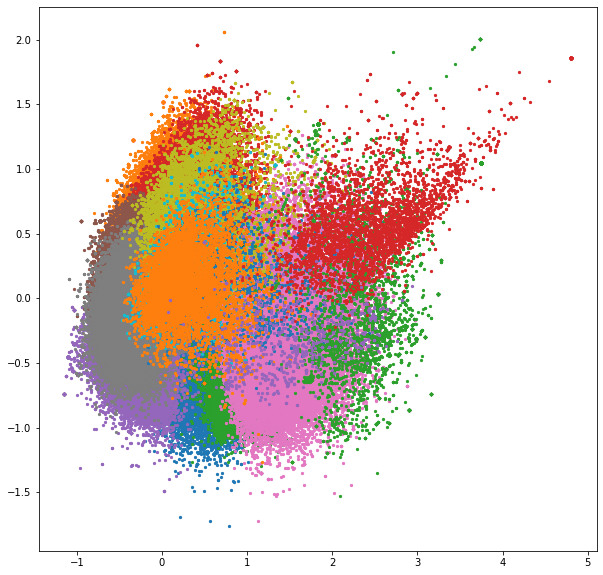

In [45]:
parse_no_save(km_pred, km_centers)